Hello Friends! I am excited to present my perspective of Titanic problem. 

Targeted Audience
1. Who wants to start with Kaggle and reach Top 5% in the competition
2. Implement various classification algorithms inlcuing most trending one i.e XGBoost
3. Understand Titanic use case and solve similar classification problem.

Let me first summarize what I have done in this project.

1. Data Preprocessing (Includes Exploratory data Analysis and Feature Engineering )
2. Implement various classification algorithms
3. Model Evaluation

lastly Very important one. :P  Download Submission csv
Kindly UPVOTE if you find it helful. Thank You:)

Lets START

In [1]:
#Below are packages used in project

import numpy as np # used for numpy data structures viz. 1D and 2D arrays and math functions
import pandas as pd # To extract data from cav file and store in table like sttructure ( dataframe)
import datetime 
import matplotlib.pyplot as plt #get 2D plots
import matplotlib #get 2D plots
import seaborn as sns #get 2D plots
from sklearn.metrics import confusion_matrix #get confusion matrrix viz. actual vs predicted output for model evaluation
import math  #math functions
import xgboost as xgb #to implement XGBoost algorithm
np.random.seed(2019) #Seed is set so that results (random numbers) are repeated even after running code several times
from scipy.stats import skew #statistical analysis
from scipy import stats #statistical analysis

import statsmodels #statistical analysis
from sklearn.metrics import accuracy_score #for model Evaluation
from IPython.display import FileLink #For creating download link to submission csv file

#to get plots below the code blocks
%matplotlib inline 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


**1. Data Preprocessing (Includes Exploratory data Analysis and Feature Engineering )**

In [2]:
#Read input csv files using pandas functions
train=pd.read_csv("/kaggle/input/titanic/train.csv")
test=pd.read_csv("/kaggle/input/titanic/test.csv")
submission=pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

#We will combine test and train for applying data tranformations 
train['train'] = 1 
test['train'] = 0
data = train.append(test,sort=False ,ignore_index=True)

In [3]:
#lets view few records in data
data.head()

#In Data Preprocessing, we will consider each column and transform to make them usable for model application.
#1. Age has lot many missing values, so need to impute Age
#2. From name we can get title for each passenger and use it to impute missing values in Age field
#3. Ticket and cabin column will be preprocessed and converted into categorical column
#4. Fare and Embarked column have 2 and 1 missing value respectively, we will impute them using most repetitive values

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [4]:
#lets analyse input data
data.describe()

#It can be seen that we have lot of nulls in Age and survived.
#Survived is expected to have so many nulls as we combined test and train.

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479,0.680672
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668,0.466394
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


In [5]:
data.Name.head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [6]:
#Age is very important variable and we need to impute missing values with best estimates.
#Data is Name variable can be used to extract Titles and then we can impute Age missing values with mean of those groups
#lets see how we will do this.
data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(data['Title'], data['Sex'])
data = data.drop('Name',axis=1)

#let's replace a few titles -> "other" and fix a few titles
data['Title'] = np.where((data.Title=='Capt') |(data.Title=='Dr') | (data.Title=='Countess') | (data.Title=='Don') | (data.Title=='Dona')
                        | (data.Title=='Jonkheer') | (data.Title=='Lady') | (data.Title=='Sir') | (data.Title=='Major') | (data.Title=='Rev') | (data.Title=='Col'),'Other',data.Title)
data['Title'] = data['Title'].replace('Ms','Miss')
data['Title'] = data['Title'].replace('Mlle','Miss')
data['Title'] = data['Title'].replace('Mme','Mrs')

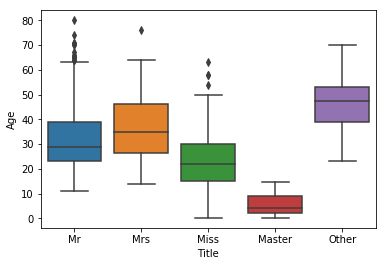

In [7]:
#Lets observe how age is correlated with Title
sns.boxplot(data = data, x = "Title", y = "Age")

In [8]:
data.groupby('Title').Age.mean()

Title
Master     5.482642
Miss      21.824366
Mr        32.252151
Mrs       36.918129
Other     45.178571
Name: Age, dtype: float64

In [9]:
#We will impute Age missing values as below
data['Age'] = np.where((data.Age.isnull()) & (data.Title=='Master'),5,
                        np.where((data.Age.isnull()) & (data.Title=='Miss'),22,
                                 np.where((data.Age.isnull()) & (data.Title=='Mr'),32,
                                          np.where((data.Age.isnull()) & (data.Title=='Mrs'),37,
                                                  np.where((data.Age.isnull()) & (data.Title=='Other'),45,data.Age))))) 

#Converting Age to 

In [10]:
#Ticket column is quite random but we can use information from it and check how it describes our dependent varaible i.e survided
import string
TypeOfTicket = []
for i in range(len(data.Ticket)):
    ticket = data.Ticket.iloc[i]
    for c in string.punctuation:
                ticket = ticket.replace(c,"")
                splited_ticket = ticket.split(" ")   
    if len(splited_ticket) == 1:
                TypeOfTicket.append('NO')
    else: 
                TypeOfTicket.append(splited_ticket[0])
            
data['TypeOfTicket'] = TypeOfTicket

data.TypeOfTicket.value_counts()
data['TypeOfTicket'] = np.where((data.TypeOfTicket!='NO') & (data.TypeOfTicket!='PC') & (data.TypeOfTicket!='CA') & 
                                (data.TypeOfTicket!='A5') & (data.TypeOfTicket!='SOTONOQ'),'other',data.TypeOfTicket)
data = data.drop('Ticket',axis=1)

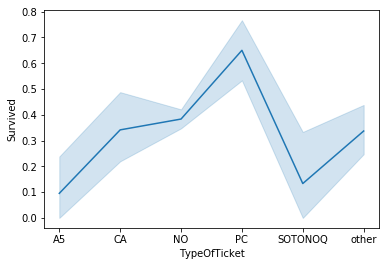

In [11]:
#Lets observe how age is correlated with Title
sns.lineplot(data = data, x = "TypeOfTicket", y = "Survived")

#It can be seen that typeOfTicket is certainly explaining Survived.
#passengers holding certain type of tickets had better chance of survival

In [12]:
data.Embarked.value_counts()
# imputing value of Embarked with 'S' which has most number of occurences
data.Embarked=data.Embarked.fillna("S")

In [13]:
data["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [14]:
# Replace the Cabin number by first letter and with 'M' if Null 
data["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'M' for i in data['Cabin'] ])

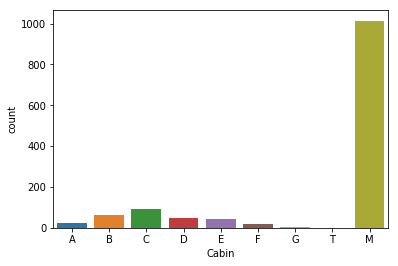

In [15]:
sns.countplot(data["Cabin"],order=['A','B','C','D','E','F','G','T','M'])
#it cn be seen that most passengers have unkown cabin number which may suggest that 
#these passengers were not alloted any cabins

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


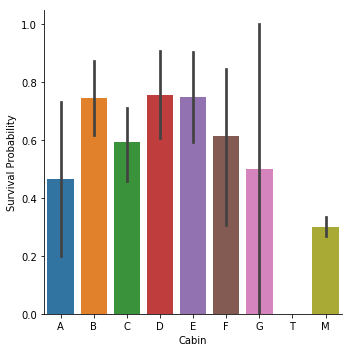

In [16]:
#lets see Survival probablity vs Cabin 
g = sns.factorplot(y="Survived",x="Cabin",data=data,kind="bar",order=['A','B','C','D','E','F','G','T','M'])
g = g.set_ylabels("Survival Probability")

It can be seen that passengers not having cabins i.e M have low survival probality compared to others

In [17]:
#Fill Fare NA with 0 
data.Fare=data.Fare.fillna(0)

In [18]:
#check which columns are having nulls
data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Sex               0
Age               0
SibSp             0
Parch             0
Fare              0
Cabin             0
Embarked          0
train             0
Title             0
TypeOfTicket      0
dtype: int64

In [19]:
#Convert all categorical variables to their dummies for model application
data = pd.get_dummies(data)

In [20]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'train', 'Sex_female', 'Sex_male', 'Cabin_A', 'Cabin_B', 'Cabin_C',
       'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_M', 'Cabin_T',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Other', 'TypeOfTicket_A5',
       'TypeOfTicket_CA', 'TypeOfTicket_NO', 'TypeOfTicket_PC',
       'TypeOfTicket_SOTONOQ', 'TypeOfTicket_other'],
      dtype='object')

In [21]:
#split data into train and test
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(data[data.Survived.isnull()==False].drop('Survived',axis=1),data.Survived[data.Survived.isnull()==False],test_size=0.30, random_state=2019)

In [22]:
#Model_eval will store the results of accuracy scroe of each model
model_eval = pd.DataFrame({'Model': [],'Accuracy Score': []})

**2. Implement various classification algorithms

We will apply below classification algorithms in the order and compare their accuracy score
1. Logistic Regression 
2. Decision Tree
3. Random Forest
4. SVC
5. XGBoost

In [23]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['LogisticRegression'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)]})
model_eval = model_eval.append(res)
pd.crosstab(testY, y_pred, rownames=['Actual'], colnames=['Predicted'])

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Predicted,0.0,1.0
Actual,,
0.0,152,24
1.0,21,71


In [24]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=4)
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['DecisionTreeClassifier'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)]})
model_eval = model_eval.append(res)
pd.crosstab(testY, y_pred, rownames=['Actual'], colnames=['Predicted'])

Predicted,0.0,1.0
Actual,,
0.0,149,27
1.0,25,67


In [25]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=2500, max_depth=4)
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['RandomForestClassifier'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)]})
model_eval = model_eval.append(res)
pd.crosstab(testY, y_pred, rownames=['Actual'], colnames=['Predicted'])

Predicted,0.0,1.0
Actual,,
0.0,153,23
1.0,27,65


In [26]:
from sklearn.svm import SVC
model = SVC()
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['SVC'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)]})
model_eval = model_eval.append(res)
pd.crosstab(testY, y_pred, rownames=['Actual'], colnames=['Predicted'])

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Predicted,0.0,1.0
Actual,,
0.0,162,14
1.0,82,10


In [27]:
from xgboost.sklearn import XGBClassifier
model = XGBClassifier(learning_rate=0.0001,n_estimators=2500,
                                max_depth=4, min_child_weight=0,
                                gamma=0, subsample=0.7,
                                colsample_bytree=0.7,
                                scale_pos_weight=1, seed=21,
                                reg_alpha=0.00006)
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['XGBClassifier'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)]})
model_eval= model_eval.append(res)
pd.crosstab(testY, y_pred, rownames=['Actual'], colnames=['Predicted'])

Predicted,0.0,1.0
Actual,,
0.0,154,22
1.0,23,69


**3. Model Evaluation****

In [28]:
#lets see how the models performed overall
model_eval

,Model,Accuracy Score
0,LogisticRegression,0.832090
0,DecisionTreeClassifier,0.805970
0,RandomForestClassifier,0.813433
0,SVC,0.641791
0,XGBClassifier,0.832090


In [29]:
#It can be seen that XGboost fared really good and we can use it to submit our results
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
trainX = data[data.Survived.isnull()==False].drop(['Survived','train'],axis=1)
trainY = data.Survived[data.Survived.isnull()==False]
testX = data[data.Survived.isnull()==True].drop(['Survived','train'],axis=1)
model = XGBClassifier(learning_rate=0.0001,n_estimators=2500,
                                max_depth=4, min_child_weight=0,
                                gamma=0, subsample=0.7,
                                colsample_bytree=0.7,
                                scale_pos_weight=1, seed=21,
                                reg_alpha=0.00006)
model.fit(trainX, trainY)
test = data[data.train==0]
test['Survived'] = model.predict(testX).astype(int)
test = test.reset_index()
test[['PassengerId','Survived']].to_csv("submissionXGB.csv",index=False)
FileLink(r'submissionXGB.csv')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


/kaggle/working/submissionXGB.csv